# Vehicle DB Exploration

[Link documentation here](https://vehicledatabases.com/)

In [ ]:
import requests 

api_key="[INSERT YOUR API KEY]"

In [ ]:
import pandas as pd
import json
import sys

In [ ]:
start_year = 2019
end_year = 2025
vehicle_year_make_model = []
counter = 0

def get_vehicle_make_year(year):
    url = "https://api.vehicledatabases.com/market-value/options/v3/make/"+ str(year)
    payload={}
    headers = {
        'x-AuthKey': api_key
    }
    try:
        result = json.loads((requests.request("GET", url, headers=headers, data=payload)).text)
        if "status" in result and result["status"] == "success":
            return result
        else:
            print(result)
    except ValueError:
        print(ValueError)

def get_vehicle_model_make_year(year, make):
    url = "https://api.vehicledatabases.com/market-value/options/v3/model/" + str(year) + "/" + make
    payload={}
    headers = {
        'x-AuthKey': api_key
    }
    try:
        result = json.loads((requests.request("GET", url, headers=headers, data=payload)).text)
        if "status" in result and result["status"] == "success":
            return get_vehicle_model_make_year_electric(result, year, make)
        else:
            print(result)
    except ValueError:
        print(ValueError)

def get_vehicle_model_make_year_electric(result_vehicle_model_make_year, year, make):
    url = "https://api.vehicledatabases.com/electric-vehicle/options/v2/model/" + str(year) + "/" + make
    payload={}
    headers = {
        'x-AuthKey': api_key
    }
    try:
        result_vehicle_model_make_year_electric = json.loads((requests.request("GET", url, headers=headers, data=payload)).text)
        if "status" in result_vehicle_model_make_year_electric and result_vehicle_model_make_year_electric["status"] == "success":
            if "data" in result_vehicle_model_make_year_electric and len(result_vehicle_model_make_year_electric["data"]) > 0:
                result_vehicle_model_make_year["data"]["electric_models"] = result_vehicle_model_make_year_electric["data"]
            else:
                result_vehicle_model_make_year["data"]["electric_models"] = []
            return result_vehicle_model_make_year
        else:
            print(result_vehicle_model_make_year_electric)
    except ValueError:
        print(ValueError)

for year in range(start_year, end_year):
    counter = 0
    result_year_make = get_vehicle_make_year(year)
    if "data" in result_year_make:
        year = str(result_year_make["data"]["year"])
        makes = result_year_make["data"]["makes"]
        for make in makes:
            counter = counter + 1
            result_year_make_model = get_vehicle_model_make_year(year, make)
            models = result_year_make_model["data"]["models"]
            electric_models = result_year_make_model["data"]["electric_models"]
            for model in models:
                sys.stdout.write(f"\rRunning... now for brand number ({counter}/{len(makes)}) position at year {year}")
                sys.stdout.flush() 
                if model in electric_models:
                    is_model_electric = True
                else:
                    is_model_electric = False
                vehicle_year_make_model.append({
                    "year": year
                    , "make": make
                    , "model": model
                    , "is_model_electric": is_model_electric
                })

vehicle_year_make_model_df = pd.DataFrame(vehicle_year_make_model)
print("DONE!")

In [ ]:
vehicle_year_make_model_df

In [ ]:
import duckdb

with duckdb.connect("vehicle_database.db") as con:
    try:
        con.sql("CREATE TABLE vehicle_year_make_model AS SELECT * FROM vehicle_year_make_model_df")
    except ValueError:
        print(ValueError)

In [ ]:
import pandas as pd
import json
import sys

vehicle_year_make_model_market_value = []
counter = 0

con = duckdb.connect("vehicle_database.db")
results = con.sql("select distinct year, make, model from vehicle_year_make_model").df()

def get_vehicle_year_make_model_market_value(year, make, model):
    url = "https://api.vehicledatabases.com/market-value/v2/ymm/" + str(year) + "/" + make + "/" + model
    payload={}
    headers = {
        'x-AuthKey': api_key
    }
    try:
        result = requests.request("GET", url, headers=headers, data=payload)
        if result["status"] == "success":
            return result.text
        else:
            print(result)
    except ValueError:
        print(ValueError)

for index, row in results.iterrows():
    counter = 0
    year = row["year"]
    make = row["make"]
    model = row["model"]
    
    result_text = get_vehicle_year_make_model_market_value(year, make, model)
    result = json.loads(result_text)

    if "data" in result:
        counter = counter + 1
        sys.stdout.write(f"\rRunning... now for brand number ({counter}/{len(makes)}) position at year {year}")
        sys.stdout.flush() 

        market_value_datas = result["data"]["market_value"]["market_value_data"]

        for market_value_data in market_value_datas:
            trim = market_value_data["trim"]
            market_value_details = market_value_data["market value"]

            for market_value_detail in market_value_details:
                condition = market_value_detail["Condition"]
                trade_in = market_value_detail["Trade-In"]
                private_party = market_value_detail["Private Party"]
                dealer_detail = market_value_detail["Dealer Retail"]

                vehicle_year_make_model_market_value.append({
                    "year": year
                    , "make": make
                    , "model": model
                    , "trim": trim
                    , "condition": condition
                    , "trade_in": trade_in
                    , "private_party": private_party
                    , "dealer_detail": dealer_detail
                })
    else:
        continue

vehicle_year_make_model_value_df = pd.DataFrame(vehicle_year_make_model_market_value)
print("DONE")
con.close()

In [2]:
with duckdb.connect("vehicle_database.db") as con:
    results = con.sql("select * from vehicle_year_make_model_value").df()

results

NameError: name 'duckdb' is not defined

In [16]:
import duckdb

sql_script = '''
    show tables
'''

with duckdb.connect("dbt_workspace/vehicle_database/data/vehicle_database.db") as con:
    temp_df = con.sql(sql_script)#.df()
    display(temp_df)

┌──────────────────────────────────────────┐
│                   name                   │
│                 varchar                  │
├──────────────────────────────────────────┤
│ bronze_vehicle_make                      │
│ bronze_vehicle_make_model                │
│ bronze_vehicle_value                     │
│ gold_summary_vehicle_brand_average_price │
│ gold_summary_vehicle_info                │
│ gold_summary_vehicle_price_distribution  │
│ silver_dim_vehicle_brand                 │
│ silver_dim_vehicle_brand_model           │
│ silver_fact_vehicle_value                │
│ vehicle_year_make_model                  │
│ vehicle_year_make_model_value            │
├──────────────────────────────────────────┤
│                 11 rows                  │
└──────────────────────────────────────────┘

In [22]:
import duckdb

sql_script = '''
    select 'harits' as new
'''

with duckdb.connect("dbt_workspace/vehicle_database/data/vehicle_database.db") as con:
    temp_df = con.sql(sql_script)#.df()
    display(temp_df)

┌─────────┐
│   new   │
│ varchar │
├─────────┤
│ harits  │
└─────────┘

In [17]:
import duckdb

with duckdb.connect("dbt_workspace/vehicle_database/data/vehicle_database.db") as con:
    results = con.sql("select * from gold_summary_vehicle_brand_average_price").df()

results

,vehicle_registered_year,dimension_type,brand_origin_country,avg_trade_in_price,avg_private_party_price,avg_dealer_price
0,2020,Other,Other,25200.730769,27633.512821,30069.945513
1,2021,Other,Other,30254.052381,32514.169048,34869.229762
2,2022,Other,Other,33802.521186,35726.050847,37894.872881
3,2019,Other,Other,22382.645911,25054.933086,27626.102230
4,2019,Average,Average,22089.315985,24710.104089,27228.137546
...,...,...,...,...,...,...
94,2021,true,true,17861.750000,20308.500000,22860.500000
95,2022,true,true,27283.071429,29307.607143,31591.035714
96,2020,false,false,25200.730769,27633.512821,30069.945513
97,2021,false,false,30313.345694,32572.569378,34926.687799


In [1]:
import duckdb

with duckdb.connect("dbt_workspace/vehicle_database/data/vehicle_database.db") as con:
    results = con.sql("select * from silver_fact_vehicle_value").df()

results

,value_id,brand_id,model_id,brand_name,model_name,model_electric_flag,vehicle_registered_year,trim_name,vehicle_condition_detail,trade_in_price_amount,private_party_price_amount,dealer_detail_price_amount,ingestion_timestamp,ingestion_date,load_timestamp
0,67c26bd203abe90215fd0987a1c39fe6,ee20afd40a90588a33d2ac680e238fe3,7d3217fdb06993cfeaffae3f74ce2c86,Acura,ILX,False,2019,Base 4dr Sedan Automatic,Average,14734.0,16845.0,18872.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
1,624ca59723441a361736572d5d50482d,ee20afd40a90588a33d2ac680e238fe3,7d3217fdb06993cfeaffae3f74ce2c86,Acura,ILX,False,2019,Technology Package 4dr Sedan Automatic,Outstanding,15965.0,18799.0,21534.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
2,38303819320d62186d4f6a8567897922,ee20afd40a90588a33d2ac680e238fe3,e4a312e5778870d106eab75746cbac86,Acura,MDX,False,2019,3.5L 4dr SH-AWD Automatic,Average,21020.0,23396.0,25678.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
3,ac2d7560da9b348904dbf34b8a01ad0c,ee20afd40a90588a33d2ac680e238fe3,e4a312e5778870d106eab75746cbac86,Acura,MDX,False,2019,3.5L Advance Pkg 4dr SH-AWD Automatic,Clean,25252.0,27793.0,30235.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
4,c803d3d64e63c85f745fcbb325e07f29,ee20afd40a90588a33d2ac680e238fe3,12caad20cb833fc8a4447c1c8c6a30c9,Acura,RDX,False,2019,Base 4dr All-wheel Drive Automatic,Clean,20021.0,22668.0,25213.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,8769c369d60f888d9f0a1b29864f7dbb,a80e565f6bc72e983219c1816b3df857,316698e63ad10232a825adad3358fb09,Mitsubishi,Outlander Sport,False,2020,2.0 BE 4dr AWC CVT,Rough,12149.0,13844.0,15527.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
3084,5d1a095acd1caf649ca9f7c6857177d5,a80e565f6bc72e983219c1816b3df857,316698e63ad10232a825adad3358fb09,Mitsubishi,Outlander Sport,False,2020,2.4 GT 4dr AWC CVT,Clean,14232.0,16748.0,19278.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
3085,b19c2a4ac9e832ac4fa4575821b7f21f,61d8c83a74bb6f7461b4554eb9a2dee4,efd756894f0f48b8f48e481f5cda40d7,KIA,RIO,False,2021,S 4dr Sedan CVT,Rough,10741.0,12674.0,14677.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370
3086,acc5676dfca6dd4a57951fbde211b870,a80e565f6bc72e983219c1816b3df857,316698e63ad10232a825adad3358fb09,Mitsubishi,Outlander Sport,False,2020,2.0 SP 4dr AWC CVT,Average,11836.0,14760.0,17684.0,2024-12-03 21:04:13.950,2024-12-03,2024-12-03 21:04:14.370


In [ ]:
import duckdb

sql_script = '''
    SELECT
        vehicle_registered_year,
        brand_name,
        AVG(trade_in_price_amount) AS avg_trade_in_price,
        AVG(private_party_price_amount) AS avg_private_party_price,
        AVG(dealer_detail_price_amount) AS avg_dealer_price
    FROM
        silver_fact_vehicle_value
    GROUP BY
        1, 2
    ORDER BY
        avg_dealer_price DESC
'''

with duckdb.connect("dbt_workspace/vehicle_database/data/vehicle_database.db") as con:
    results = con.sql(sql_script).df()

results

,vehicle_registered_year,brand_name,avg_trade_in_price,avg_private_party_price,avg_dealer_price
0,2020,Rolls-Royce,160439.000000,174718.250000,189101.750000
1,2021,Bentley,102186.875000,106741.750000,111495.375000
2,2020,Bentley,90329.250000,96699.250000,103114.625000
3,2021,Toyota,80788.750000,84829.750000,89037.250000
4,2021,BMW,64223.625000,68790.875000,73545.625000
...,...,...,...,...,...
68,2019,KIA,12838.107143,15408.928571,17882.285714
69,2020,KIA,13231.142857,15307.571429,17386.392857
70,2021,KIA,11530.666667,13560.250000,15674.333333
71,2019,Nissan,11342.916667,13547.000000,15668.083333


In [9]:
import duckdb

sql_script = '''
    SELECT 
        brand_name,
        vehicle_condition_detail,
        vehicle_registered_year,
        trade_in_price_amount,
        private_party_price_amount,
        dealer_detail_price_amount,
        COUNT(*) AS frequency
    FROM 
        silver_fact_vehicle_value
    GROUP BY 
        1,2,3,4,5,6
'''

with duckdb.connect("dbt_workspace/vehicle_database/data/vehicle_database.db") as con:
    results = con.sql(sql_script).df()

results

,brand_name,vehicle_condition_detail,vehicle_registered_year,trade_in_price_amount,private_party_price_amount,dealer_detail_price_amount,frequency
0,Acura,Average,2019,14734.0,16845.0,18872.0,1
1,Alfa Romeo,Outstanding,2019,14003.0,16736.0,19373.0,1
2,Genesis,Outstanding,2019,26968.0,29554.0,32061.0,1
3,GMC,Average,2019,25856.0,27840.0,29747.0,1
4,GMC,Average,2019,22603.0,25211.0,27717.0,1
...,...,...,...,...,...,...,...
3083,Chevrolet,Rough,2021,23806.0,25768.0,27805.0,1
3084,Honda,Rough,2021,24674.0,26769.0,28934.0,1
3085,Cadillac,Average,2020,21882.0,23224.0,24565.0,1
3086,Mitsubishi,Average,2020,12355.0,14451.0,16547.0,1


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

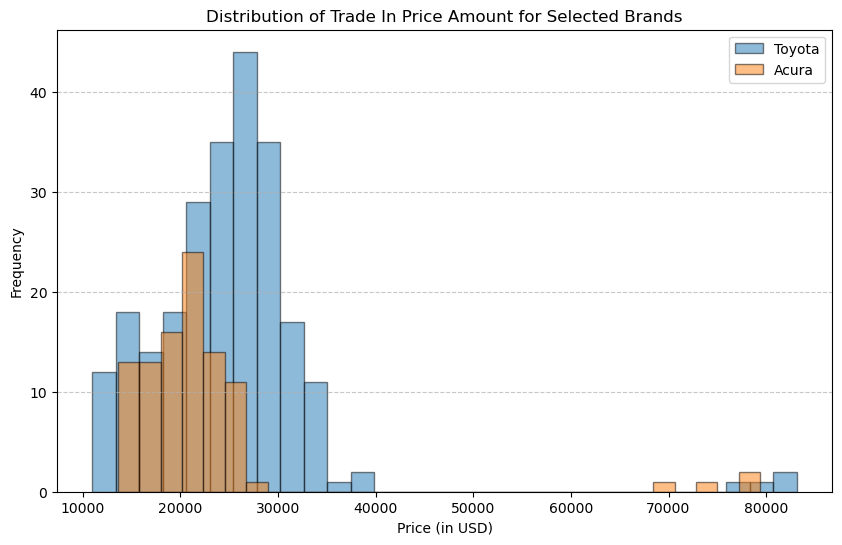

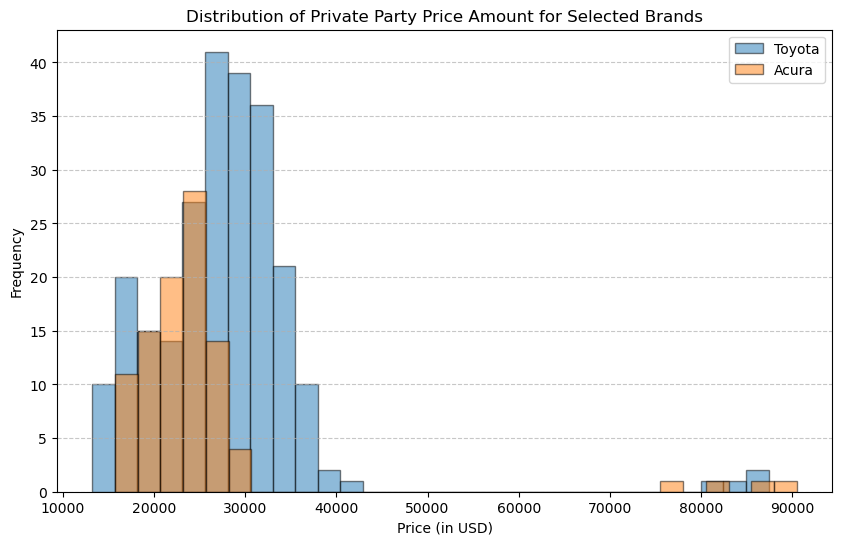

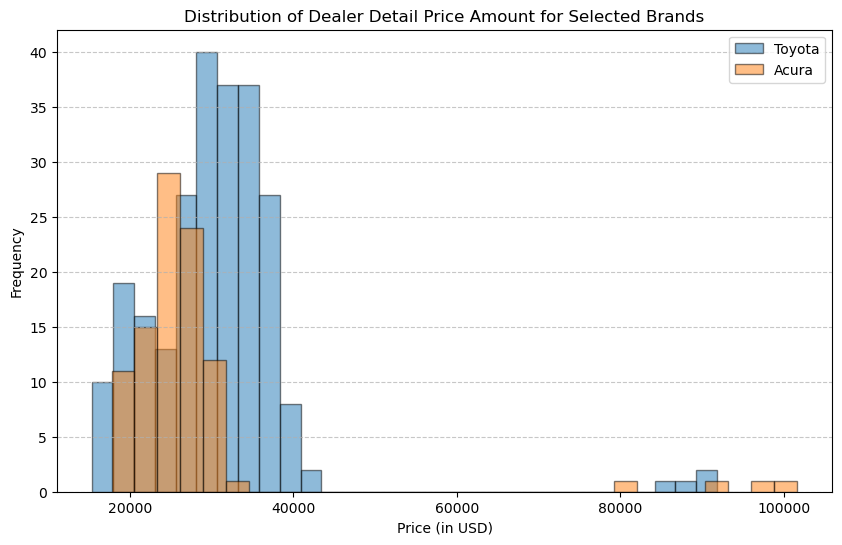

In [13]:
brands = ['Toyota', 'Acura']
filtered_data = results[results['brand_name'].isin(brands)]

# Define price columns to analyze
price_columns = ['trade_in_price_amount', 'private_party_price_amount', 'dealer_detail_price_amount']

# Plot distributions for each price column
for column in price_columns:
    plt.figure(figsize=(10, 6))
    
    for brand in brands:
        brand_data = filtered_data[filtered_data['brand_name'] == brand]
        plt.hist(brand_data[column], bins=30, alpha=0.5, label=brand, edgecolor='black')
    
    plt.title(f'Distribution of {column.replace("_", " ").title()} for Selected Brands')
    plt.xlabel('Price (in USD)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()